In [ ]:
!pip install wordcloud

In [1]:
import json
import os
from datetime import datetime
import warnings

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

import pyspark
from pyspark import SparkContext 
from pyspark.sql import SparkSession 
from pyspark.sql import SQLContext

from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import functions as F
from textblob import TextBlob

from wordcloud import WordCloud

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)
spark = SparkSession.builder.master("localhost").appName("Project").getOrCreate()
sql = SQLContext(sc)

sc
spark

In [2]:
path = "hdfs://localhost:9000/tweets/tweepy"
df_tweepy = spark.read.json(path, multiLine=True)
df_tweepy.show(1)

+------------+-----------+--------------------+------------------+--------------------+-----------------+--------------+---------+--------------------+----+-------------------+-------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+---------------+----+------------+-----+------------------+-------------+----------------+--------------------+-------------+---------+--------------------+--------------------+---------+--------------------+---------------------+
|contributors|coordinates|          created_at|display_text_range|            entities|extended_entities|favorite_count|favorited|           full_text| geo|                 id|             id_str|in_reply_to_screen_name|in_reply_to_status_id|in_reply_to_status_id_str|in_reply_to_user_id|in_reply_to_user_id_str|is_quote_status|lang|    metadata|place|possibly_sensitive|quoted_status|quoted_status_id|quoted_status_id_str|retweet_count|retweeted|    retwee

In [3]:
path = "hdfs://localhost:9000/tweets/twarc"
df_twarc = spark.read.json(path)
df_twarc.show(1)

+------------+-----------+--------------------+------------------+--------------------+-----------------+--------------+---------+--------------------+----+-------------------+-------------------+-----------------------+---------------------+-------------------------+-------------------+-----------------------+---------------+----+-----+------------------+-------------+----------------+--------------------+-----------------------+-------------+---------+--------------------+--------------------+---------+--------------------+------------------+---------------------+--------------+
|contributors|coordinates|          created_at|display_text_range|            entities|extended_entities|favorite_count|favorited|           full_text| geo|                 id|             id_str|in_reply_to_screen_name|in_reply_to_status_id|in_reply_to_status_id_str|in_reply_to_user_id|in_reply_to_user_id_str|is_quote_status|lang|place|possibly_sensitive|quoted_status|quoted_status_id|quoted_status_id_str|qu

In [4]:
print("Tweepy Count: ", df_tweepy.count())
print("Twarc Count: ", df_twarc.count())

Tweepy Count:  7004
Twarc Count:  691244


In [5]:
tweet_tweepy = df_tweepy.select('created_at', 'id_str', 'full_text', 'entities.hashtags', 'lang').toPandas()
tweet_twarc = df_twarc.select('created_at', 'id_str', 'full_text', 'entities.hashtags', 'lang').toPandas()

tweets_all = pd.concat([tweet_tweepy, tweet_twarc])

tweets_all.count()

created_at    698248
id_str        698248
full_text     698248
hashtags      698248
lang          698248
dtype: int64

In [6]:
spark_tweets_all = spark.createDataFrame(tweets_all)
spark_tweets_all.createOrReplaceTempView('tweets_table')

result_some = spark.sql("select * from tweets_table where lang='en' ")
result_some.show(5)

+--------------------+-------------------+--------------------+--------------------+----+
|          created_at|             id_str|           full_text|            hashtags|lang|
+--------------------+-------------------+--------------------+--------------------+----+
|Tue Apr 06 02:19:...|1379257519705587713|RT @PattyHajdu: I...|                  []|  en|
|Thu Apr 01 13:46:...|1377618468175028231|RT @GordonGChang:...|[{[63, 69], China...|  en|
|Thu Apr 01 13:46:...|1377618467298414604|RT @dgurdasani1: ...|                  []|  en|
|Thu Apr 01 13:46:...|1377618467294167056|RT @ak_mack: Ther...|                  []|  en|
|Thu Apr 01 13:46:...|1377618466748968972|RT @thelucyjohnst...|                  []|  en|
+--------------------+-------------------+--------------------+--------------------+----+
only showing top 5 rows



In [ ]:
# Count hashtags

In [8]:
hashtag = spark.sql("select created_at, explode(hashtags.text) as text from tweets_table where lang='en'").toPandas()
hashtag['date'] = pd.to_datetime(hashtag['created_at']).dt.date
hashtag['date'] = pd.to_datetime(hashtag['date'])
hashtag = hashtag.drop('created_at', axis=1)

hashtag

,text,date
0,China,2021-04-01
1,COVID19,2021-04-01
2,coronavirus,2021-04-01
3,test,2021-04-01
4,COVID,2021-04-01
...,...,...
121971,CoronaVirus,2020-03-17
121972,YoMeQuedoEnCasa,2020-03-17
121973,covid19,2020-03-17
121974,coronavirus,2020-03-17


In [9]:
omitted_hashtags = ['Covid_19', 'COVID2019', 'Covid19', 'Corona', 'corona', 
                    'COVID19', 'COVID', 'covid19', 'covid-19', 'Coronavirus', 
                    'CoronaVirus', 'coronavirus', 'vaccination', 'elections']

df = hashtag[~hashtag['text'].isin(omitted_hashtags)]
df

,text,date
0,China,2021-04-01
3,test,2021-04-01
8,PartyHard,2021-04-01
9,DAX30,2021-04-01
10,CAC40,2021-04-01
...,...,...
121967,snowshill,2020-03-17
121968,मंगल_मूरति_मारुत_नन्दन,2020-03-17
121969,Ramkatha,2020-03-17
121970,Namaste,2020-03-17


Text(0, 0.5, 'Count')

/Users/shivikaprasanna/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/shivikaprasanna/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0, flags=flags)


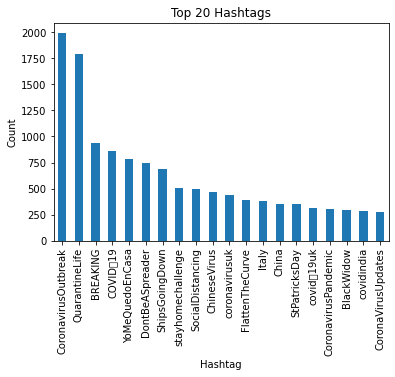

In [10]:
df_grouped = df.groupby('text').size().sort_values(ascending=False)
ax = df_grouped.head(20).plot.bar(title="Top 20 Hashtags")
ax.set_xlabel("Hashtag")
ax.set_ylabel("Count")

(0.0, 3.0)

/Users/shivikaprasanna/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 120047 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/shivikaprasanna/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 120050 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/shivikaprasanna/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 120055 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/shivikaprasanna/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 120019 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/shivikaprasanna/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 120047 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/shivi

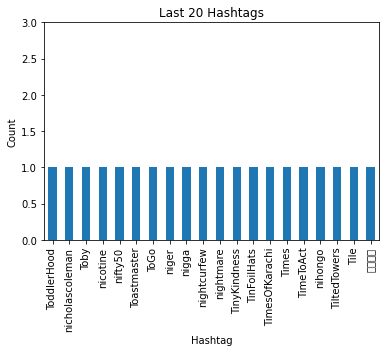

In [11]:
ax = df_grouped.tail(20).plot.bar(title="Last 20 Hashtags")
ax.set_xlabel("Hashtag")
ax.set_ylabel("Count")
ax.set_ylim(0,3)

Text(0, 0.5, 'Count')

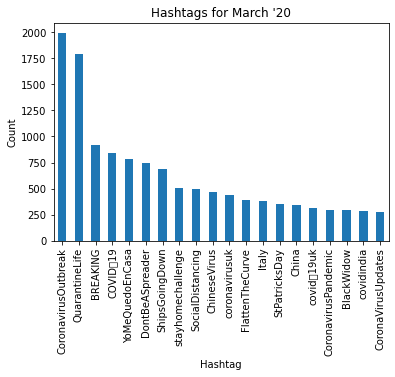

In [12]:
mar = df[df['date'].dt.month == 3]
mar = mar.groupby('text').size().sort_values(ascending=False)
# print(mar)
ax = mar.head(20).plot.bar(title='Hashtags for March \'20')
ax.set_xlabel("Hashtag")
ax.set_ylabel("Count")

Text(0, 0.5, 'Count')

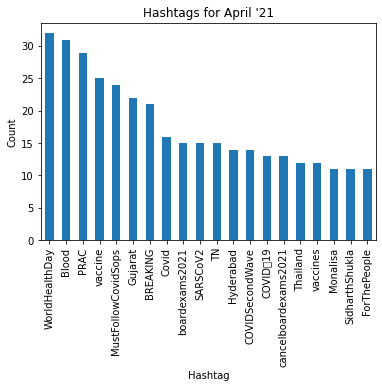

In [13]:
apr = df[df['date'].dt.month == 4]
apr = apr.groupby('text').size().sort_values(ascending=False)
# print(apr)
ax = apr.head(20).plot.bar(title='Hashtags for April \'21')
ax.set_xlabel("Hashtag")
ax.set_ylabel("Count")

In [ ]:
# Sentiment Analysis

In [14]:
text_new = spark.sql("select id_str, full_text, hashtags.text as hashtag, created_at from tweets_table where lang='en' ").toPandas()
text_new["processed_tweet"] = ""
text_new["polarity"] = ""
text_new["sentiment"] = ""
text_new['date'] = pd.to_datetime(text_new['created_at']).dt.date
text_new['date'] = pd.to_datetime(text_new['date'])
text_new = text_new.drop('created_at', 1)
text_new


,id_str,full_text,hashtag,processed_tweet,polarity,sentiment,date
0,1379257519705587713,"RT @PattyHajdu: In Ontario, we’ve provided 4,0...",[],,,,2021-04-06
1,1377618468175028231,RT @GordonGChang: A great disease began with a...,"[China, COVID19, coronavirus]",,,,2021-04-01
2,1377618467298414604,RT @dgurdasani1: Many of us have repeatedly sa...,[],,,,2021-04-01
3,1377618467294167056,RT @ak_mack: There are now 4 RT &amp; Sputnik ...,[],,,,2021-04-01
4,1377618466748968972,RT @thelucyjohnston: As we reported in Jan - s...,[],,,,2021-04-01
...,...,...,...,...,...,...,...
411569,1239939165518622721,RT @DavidLat: FYI - I have a confirmed case of...,"[covid19, coronavirus]",,,,2020-03-17
411570,1239939165371789312,RT @RichaChadha: This is the most irresponsibl...,[],,,,2020-03-17
411571,1239939169906036736,RT @iya_lucy: My boyfriend’s boss is scared of...,[],,,,2020-03-17
411572,1239939169704726530,Coronavirus Update: Small group keeps NYC's St...,[],,,,2020-03-17


In [15]:
def emoji(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :') , :O
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:O)', ' positiveemoji ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' positiveemoji ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' positiveemoji ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-; , @-)
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;|@-\))', ' positiveemoji ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:, :-/ , :-|
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:|:-/|:-\|)', ' negativeemoji ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' negativeemoji ', tweet)
    return tweet

def preprocessing(tweet):
    tweet = re.sub('@[^\s]+', '', tweet)                              # Removes usernames
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', tweet)   # Remove URLs
    tweet = re.sub(r"\d+", " ", str(tweet))                           # Removes all digits
    tweet = re.sub('&quot;'," ", tweet)                               # Remove (&quot;) 
    tweet = emoji(tweet)                                              # Replaces Emojis
    tweet = re.sub(r"\b[a-zA-Z]\b", "", str(tweet))                   # Removes all single characters
    tweet = re.sub(r"[^\w\s]", " ", str(tweet))                       # Removes all punctuation 
    tweet = re.sub(r'(.)\1+', r'\1\1', tweet)                         # Convert more than 2 letter repetitions to 2 letter
    tweet = re.sub(r"\s+", " ", str(tweet))                           # Replaces double spaces with single space    
    tweet = re.sub('RT', "", tweet)
    return tweet

def polarity_detection(text):
    return TextBlob(text).sentiment.polarity

def subjectivity_detection(text):
    return TextBlob(text).sentiment.subjectivity
 
for index, item in text_new.iterrows():
    pre = preprocessing(item[1])
    polarity = polarity_detection(pre)
    if polarity > 0:
        text_new.at[index, "sentiment"] = "Positive"
    elif polarity < 0:
        text_new.at[index, "sentiment"] = "Negative"
    else:
        text_new.at[index, "sentiment"] = "Neutral"
    text_new.at[index, "processed_tweet"] = pre
    text_new.at[index, "polarity"] = polarity

In [16]:
text_new

,id_str,full_text,hashtag,processed_tweet,polarity,sentiment,date
0,1379257519705587713,"RT @PattyHajdu: In Ontario, we’ve provided 4,0...",[],In Ontario we ve provided vaccines and they h...,0.5,Positive,2021-04-06
1,1377618468175028231,RT @GordonGChang: A great disease began with a...,"[China, COVID19, coronavirus]",great disease began with great crime In China...,0.8,Positive,2021-04-01
2,1377618467298414604,RT @dgurdasani1: Many of us have repeatedly sa...,[],Many of us have repeatedly said that COVID ou...,0.1125,Positive,2021-04-01
3,1377618467294167056,RT @ak_mack: There are now 4 RT &amp; Sputnik ...,[],There are now amp Sputnik columnists hosts e...,0,Neutral,2021-04-01
4,1377618466748968972,RT @thelucyjohnston: As we reported in Jan - s...,[],As we reported in Jan scary models about new ...,0.0590909,Positive,2021-04-01
...,...,...,...,...,...,...,...
411569,1239939165518622721,RT @DavidLat: FYI - I have a confirmed case of...,"[covid19, coronavirus]",FYI have confirmed case of covid aka coronavi...,0.4,Positive,2020-03-17
411570,1239939165371789312,RT @RichaChadha: This is the most irresponsibl...,[],This is the most irresponsible thing any one ...,0.212121,Positive,2020-03-17
411571,1239939169906036736,RT @iya_lucy: My boyfriend’s boss is scared of...,[],My boyfriend boss is scared of getting the co...,0.1,Positive,2020-03-17
411572,1239939169704726530,Coronavirus Update: Small group keeps NYC's St...,[],Coronavirus Update Small group keeps NYC St Pa...,-0.133333,Negative,2020-03-17


sentiment
Negative     86986
Neutral     162407
Positive    162181
dtype: int64


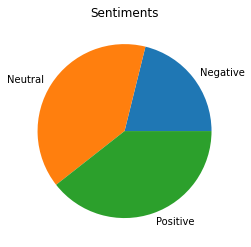

In [17]:
a = text_new.groupby('sentiment').size()
print(a)
plt.axis('off')
a.plot.pie(figsize=(4,4),title='Sentiments')

sentiment
Negative     85731
Neutral     159857
Positive    158981
dtype: int64


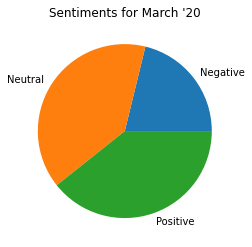

In [18]:
mar = text_new[text_new['date'].dt.month == 3]
mar = mar.groupby('sentiment').size()
print(mar)
plt.axis('off')
mar.plot.pie(figsize=(4,4),title='Sentiments for March \'20')

sentiment
Negative    1255
Neutral     2549
Positive    3200
dtype: int64


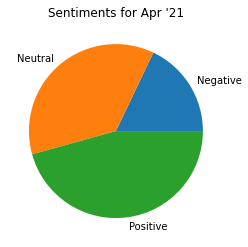

In [19]:
apr = text_new[text_new['date'].dt.month == 4]
apr = apr.groupby('sentiment').size()
print(apr)
plt.axis('off')
apr.plot.pie(figsize=(4,4),title='Sentiments for Apr \'21')

sentiment
Neutral    1
dtype: int64


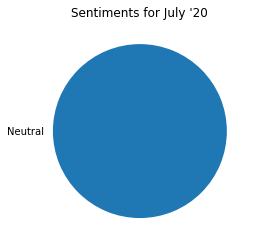

In [20]:
jul = text_new[text_new['date'].dt.month == 7]
jul = jul.groupby('sentiment').size()
print(jul)
plt.axis('off')
jul.plot.pie(figsize=(4,4),title='Sentiments for July \'20')

In [ ]:
# Exploding hashtags to see what hashtags drive the sentiments of the tweets

In [21]:
text = spark.sql("select id_str, full_text, explode(hashtags.text) as hashtag, created_at from tweets_table where lang='en' ").toPandas()
text["processed_tweet"] = ""
text["polarity"] = ""
text["sentiment"] = ""
text['date'] = pd.to_datetime(text['created_at']).dt.date
text['date'] = pd.to_datetime(text['date'])
text = text.drop('created_at', 1)
text

,id_str,full_text,hashtag,processed_tweet,polarity,sentiment,date
0,1377618468175028231,RT @GordonGChang: A great disease began with a...,China,,,,2021-04-01
1,1377618468175028231,RT @GordonGChang: A great disease began with a...,COVID19,,,,2021-04-01
2,1377618468175028231,RT @GordonGChang: A great disease began with a...,coronavirus,,,,2021-04-01
3,1377618465314471938,"RT @medical_xpress: Fast, portable #test can d...",test,,,,2021-04-01
4,1377618464425308160,The White House has announced plans to expand ...,COVID,,,,2021-04-01
...,...,...,...,...,...,...,...
121971,1239939165388767232,RT @cesc4official: Day 4 of isolation and peop...,CoronaVirus,,,,2020-03-17
121972,1239939165388767232,RT @cesc4official: Day 4 of isolation and peop...,YoMeQuedoEnCasa,,,,2020-03-17
121973,1239939165518622721,RT @DavidLat: FYI - I have a confirmed case of...,covid19,,,,2020-03-17
121974,1239939165518622721,RT @DavidLat: FYI - I have a confirmed case of...,coronavirus,,,,2020-03-17


In [22]:
def emoji(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :') , :O
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\)|:O)', ' positiveemoji ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' positiveemoji ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' positiveemoji ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-; , @-)
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;|@-\))', ' positiveemoji ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:, :-/ , :-|
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:|:-/|:-\|)', ' negativeemoji ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' negativeemoji ', tweet)
    return tweet

def preprocessing(tweet):
    tweet = re.sub('@[^\s]+', '', tweet)                              # Removes usernames
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', tweet)   # Remove URLs
    tweet = re.sub(r"\d+", " ", str(tweet))                           # Removes all digits
    tweet = re.sub('&quot;'," ", tweet)                               # Remove (&quot;) 
    tweet = emoji(tweet)                                              # Replaces Emojis
    tweet = re.sub(r"\b[a-zA-Z]\b", "", str(tweet))                   # Removes all single characters
    tweet = re.sub(r"[^\w\s]", " ", str(tweet))                       # Removes all punctuations
    tweet = re.sub(r'(.)\1+', r'\1\1', tweet)                         # Convert more than 2 letter repetitions to 2 letter
    tweet = re.sub(r"\s+", " ", str(tweet))                           # Replaces double spaces with single space    
    tweet = re.sub('RT', "", tweet)
    return tweet

def polarity_detection(text):
    return TextBlob(text).sentiment.polarity

def subjectivity_detection(text):
    return TextBlob(text).sentiment.subjectivity
 
for index, item in text.iterrows():
    pre = preprocessing(item[1])
    polarity = polarity_detection(pre)
    if polarity > 0:
        text.at[index, "sentiment"] = "Positive"
    elif polarity < 0:
        text.at[index, "sentiment"] = "Negative"
    else:
        text.at[index, "sentiment"] = "Neutral"
    text.at[index, "processed_tweet"] = pre
    text.at[index, "polarity"] = polarity

In [23]:
text

,id_str,full_text,hashtag,processed_tweet,polarity,sentiment,date
0,1377618468175028231,RT @GordonGChang: A great disease began with a...,China,great disease began with great crime In China...,0.8,Positive,2021-04-01
1,1377618468175028231,RT @GordonGChang: A great disease began with a...,COVID19,great disease began with great crime In China...,0.8,Positive,2021-04-01
2,1377618468175028231,RT @GordonGChang: A great disease began with a...,coronavirus,great disease began with great crime In China...,0.8,Positive,2021-04-01
3,1377618465314471938,"RT @medical_xpress: Fast, portable #test can d...",test,Fast portable test can diagnose COVID and tra...,0.2,Positive,2021-04-01
4,1377618464425308160,The White House has announced plans to expand ...,COVID,The White House has announced plans to expand ...,0.0590909,Positive,2021-04-01
...,...,...,...,...,...,...,...
121971,1239939165388767232,RT @cesc4official: Day 4 of isolation and peop...,CoronaVirus,Day of isolation and people are getting reall...,-0.333333,Negative,2020-03-17
121972,1239939165388767232,RT @cesc4official: Day 4 of isolation and peop...,YoMeQuedoEnCasa,Day of isolation and people are getting reall...,-0.333333,Negative,2020-03-17
121973,1239939165518622721,RT @DavidLat: FYI - I have a confirmed case of...,covid19,FYI have confirmed case of covid aka coronavi...,0.4,Positive,2020-03-17
121974,1239939165518622721,RT @DavidLat: FYI - I have a confirmed case of...,coronavirus,FYI have confirmed case of covid aka coronavi...,0.4,Positive,2020-03-17


sentiment
Negative    14796
Neutral     26560
Positive    28749
dtype: int64


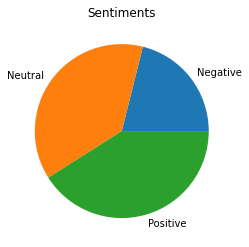

In [24]:
a = text.groupby(['id_str', 'sentiment']).size().groupby('sentiment').size()
print(a)
plt.axis('off')
a.plot.pie(figsize=(4,4),title='Sentiments')

sentiment
Negative    14477
Neutral     25850
Positive    27890
dtype: int64


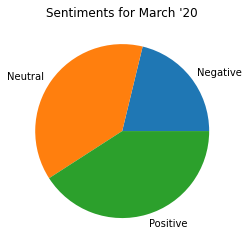

In [25]:
mar = text[text['date'].dt.month == 3]
mar = mar.groupby(['id_str', 'sentiment']).size().groupby('sentiment').size()
print(mar)
plt.axis('off')
mar.plot.pie(figsize=(4,4),title='Sentiments for March \'20')

In [26]:
mar = text[text['date'].dt.month == 3]
mar = mar.groupby('sentiment')['hashtag'].unique()
print(mar)

sentiment
Negative    [NottsOSCARS, COVIDー19, COVID19, covidー19uk, Q...
Neutral     [Coronavirus, coronavirus, DontBeASpreader, CO...
Positive    [COVID, Patient31, CoronaVirusNigeria, Coronav...
Name: hashtag, dtype: object


sentiment
Negative    319
Neutral     710
Positive    859
dtype: int64


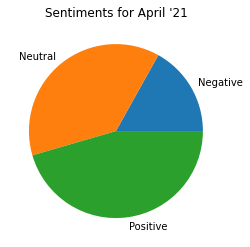

In [27]:
apr = text[text['date'].dt.month == 4]
apr
apr = apr.groupby(['id_str', 'sentiment']).size().groupby('sentiment').size()
print(apr)
plt.axis('off')
apr.plot.pie(figsize=(4,4),title='Sentiments for April \'21')

In [28]:
apr = text[text['date'].dt.month == 4]
apr = apr.groupby('sentiment')['hashtag'].unique()
print(apr)

sentiment
Negative    [COVID19, covid19, vaccine, VAXX, Cyprus, coro...
Neutral     [COVID19, PartyHard, Adivasis, Wayanad, BJP, C...
Positive    [China, COVID19, coronavirus, test, COVID, DAX...
Name: hashtag, dtype: object


Series([], dtype: int64)


TypeError: no numeric data to plot

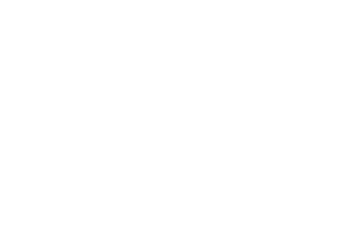

In [29]:
jul = text[text['date'].dt.month == 7]
jul
jul = jul.groupby(['id_str', 'sentiment']).size().groupby('sentiment').size()
print(jul)
plt.axis('off')

jul.plot.pie(figsize=(4,4),title='Sentiments for July \'20')

In [30]:
jul = text[text['date'].dt.month == 7]
jul = jul.groupby('sentiment')['hashtag'].unique()
print(jul)

Series([], Name: hashtag, dtype: float64)


<Figure size 3600x2400 with 0 Axes>

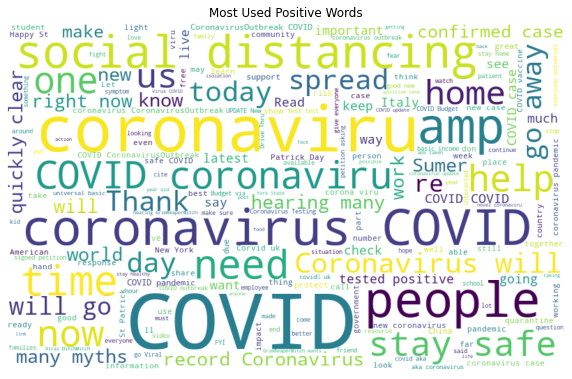

In [31]:
positive_words =' '.join([t for t in text['processed_tweet'][text['sentiment'] == "Positive"]])
wordcloud = WordCloud(width=800, height=500, random_state=21,
            max_font_size=110,background_color="rgba(255, 255, 255, 0)"
            , mode="RGBA").generate(positive_words)
plt.figure(dpi=600)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Used Positive Words")
plt.savefig('positive_words.png')
plt.show()

<Figure size 3600x2400 with 0 Axes>

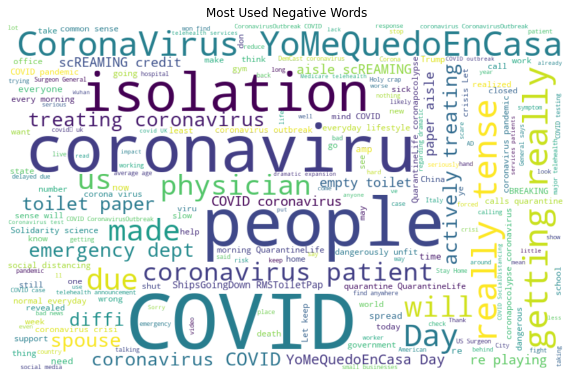

In [32]:
negative_words =' '.join([t for t in text['processed_tweet'][text['sentiment'] == "Negative"]])
wordcloud = WordCloud(width=800, height=500, random_state=21,
            max_font_size=110,background_color="rgba(255, 255, 255, 0)"
            , mode="RGBA").generate(negative_words)
plt.figure(dpi=600)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Used Negative Words")
plt.savefig('negative_words.png')
plt.show()

In [ ]:
# Evaluation

Read the subset -> text, sentiment -> WC
Read subset -> text, ground truth -> WC

Precision -> In 100, how many were correctly prediction (sentiment == gt)
-> incorrect?
-> TP/TP+FP
Recall -> TP/TP+FN
TP, FP, TN, FN

In [ ]:
text_to_save = text_new[text_new.astype(str)['hashtag'] != '[]']
text_to_save.head(100).to_csv("subset_hashtags.csv")

In [33]:
df_gt = pd.read_csv("subset_hashtags_annotated.csv", usecols=['processed_tweet', 'sentiment', 'ground truth'])
df_gt

,processed_tweet,sentiment,ground truth
0,great disease began with great crime In China...,Positive,Negative
1,Fast portable test can diagnose COVID and tra...,Positive,Positive
2,The White House has announced plans to expand ...,Positive,Positive
3,cases COVID,Neutral,Negative
4,Watch Malls and temples may be closed Wedding ...,Negative,Neutral
...,...,...,...
95,We did shots on Thursday morning COVID,Neutral,Positive
96,IndianFraudVaccines Indian Covid vaccine may ...,Positive,Negative
97,Watch Thousands gather for Mahakumbh in Harid...,Neutral,Neutral
98,Brazil reported record deaths from COVID in M...,Neutral,Negative


<Figure size 3600x2400 with 0 Axes>

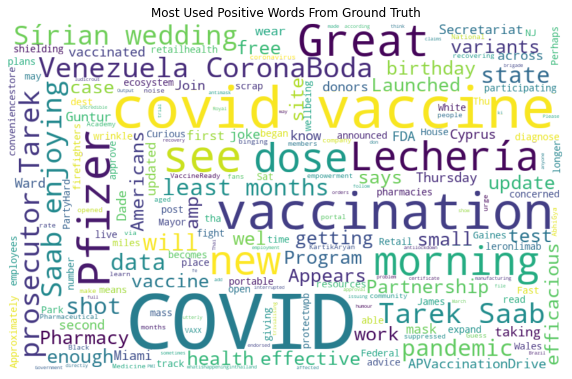

In [34]:
positive_words_gt =' '.join([t for t in df_gt['processed_tweet'][df_gt['ground truth'] == "Positive"]])
wordcloud_gt = WordCloud(width=800, height=500, random_state=21,
            max_font_size=110,background_color="rgba(255, 255, 255, 0)"
            , mode="RGBA").generate(positive_words_gt)
plt.figure(dpi=600)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_gt, interpolation="bilinear")
plt.axis('off')
plt.title("Most Used Positive Words From Ground Truth")
plt.savefig('positive_words_gt.png')
plt.show()

<Figure size 3600x2400 with 0 Axes>

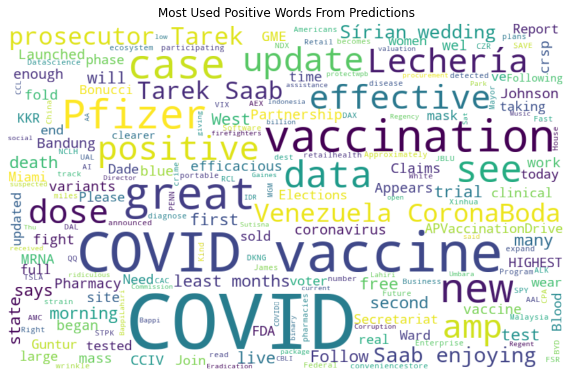

In [35]:
positive_words_proc =' '.join([t for t in df_gt['processed_tweet'][df_gt['sentiment'] == "Positive"]])
wordcloud_proc = WordCloud(width=800, height=500, random_state=21,
            max_font_size=110,background_color="rgba(255, 255, 255, 0)"
            , mode="RGBA").generate(positive_words_proc)
plt.figure(dpi=600)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_proc, interpolation="bilinear")
plt.axis('off')
plt.title("Most Used Positive Words From Predictions")
plt.savefig('positive_words_proc.png')
plt.show()

<Figure size 3600x2400 with 0 Axes>

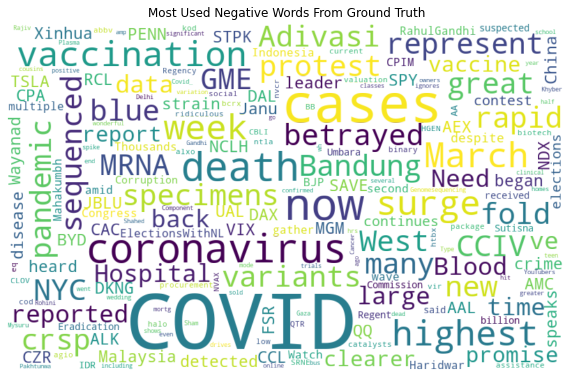

In [36]:
negative_words_gt =' '.join([t for t in df_gt['processed_tweet'][df_gt['ground truth'] == "Negative"]])
wordcloud_gt = WordCloud(width=800, height=500, random_state=21,
            max_font_size=110,background_color="rgba(255, 255, 255, 0)"
            , mode="RGBA").generate(negative_words_gt)
plt.figure(dpi=600)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_gt, interpolation="bilinear")
plt.axis('off')
plt.title("Most Used Negative Words From Ground Truth")
plt.savefig('negative_words_gt.png')
plt.show()

<Figure size 3600x2400 with 0 Axes>

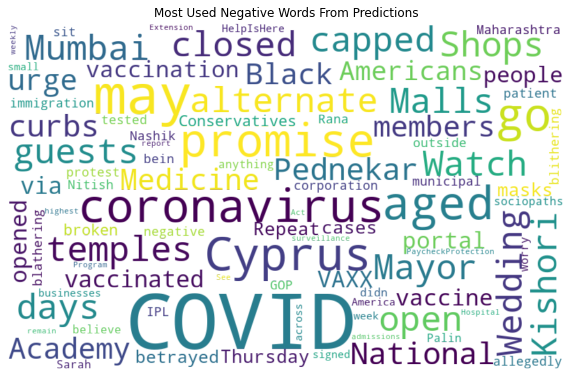

In [37]:
negative_words_proc =' '.join([t for t in df_gt['processed_tweet'][df_gt['sentiment'] == "Negative"]])
wordcloud_proc = WordCloud(width=800, height=500, random_state=21,
            max_font_size=110,background_color="rgba(255, 255, 255, 0)"
            , mode="RGBA").generate(negative_words_proc)
plt.figure(dpi=600)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_proc, interpolation="bilinear")
plt.axis('off')
plt.title("Most Used Negative Words From Predictions")
plt.savefig('negative_words_proc.png')
plt.show()

<Figure size 3600x2400 with 0 Axes>

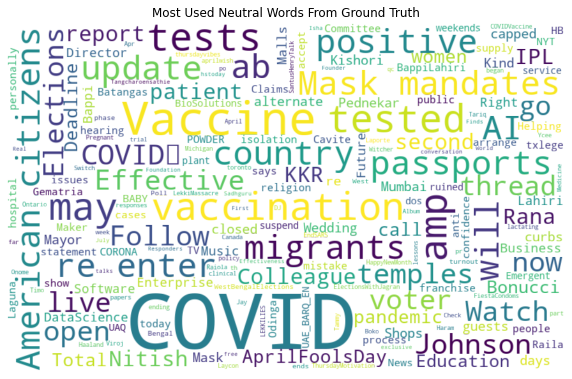

In [38]:
neutral_words_gt =' '.join([t for t in df_gt['processed_tweet'][df_gt['ground truth'] == "Neutral"]])
wordcloud_gt = WordCloud(width=800, height=500, random_state=21,
            max_font_size=110,background_color="rgba(255, 255, 255, 0)"
            , mode="RGBA").generate(neutral_words_gt)
plt.figure(dpi=600)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_gt, interpolation="bilinear")
plt.axis('off')
plt.title("Most Used Neutral Words From Ground Truth")
plt.savefig('neutral_words_gt.png')
plt.show()

<Figure size 3600x2400 with 0 Axes>

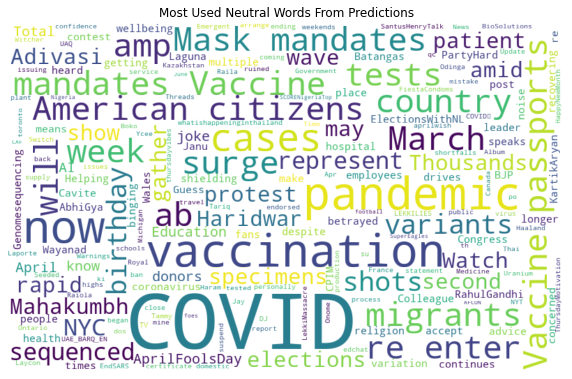

In [39]:
neutral_words_proc =' '.join([t for t in df_gt['processed_tweet'][df_gt['sentiment'] == "Neutral"]])
wordcloud_proc = WordCloud(width=800, height=500, random_state=21,
            max_font_size=110,background_color="rgba(255, 255, 255, 0)"
            , mode="RGBA").generate(neutral_words_proc)
plt.figure(dpi=600)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud_proc, interpolation="bilinear")
plt.axis('off')
plt.title("Most Used Neutral Words From Predictions")
plt.savefig('neutral_words_proc.png')
plt.show()

In [40]:
total_predictions = len(df_gt)
print(total_predictions)

100


In [41]:
correctly_predicted = df_gt[(df_gt['sentiment'] == df_gt['ground truth'])].dropna().count()
print(correctly_predicted)

print("Precision (correctly_predicted) = ", correctly_predicted/total_predictions)

processed_tweet    52
sentiment          52
ground truth       52
dtype: int64
Precision (correctly_predicted) =  processed_tweet    0.52
sentiment          0.52
ground truth       0.52
dtype: float64


In [42]:
incorrectly_predicted = df_gt[(df_gt['sentiment'] != df_gt['ground truth'])].dropna().count()
incorrectly_predicted

processed_tweet    48
sentiment          48
ground truth       48
dtype: int64